In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn.linear_model as lm

Load and Look at data

In [23]:
finches = pd.read_csv(r'../resources/finch_beaks.csv')
finches.head()

,band,year,species,beaklength,beakdepth
0,2,1975,fortis,9.4,8.0
1,9,1975,fortis,9.2,8.3
2,12,1975,fortis,9.5,7.5
3,15,1975,fortis,9.5,8.0
4,305,1975,fortis,11.5,9.9


In [25]:
finches75 = finches[finches.year==1975]
np.unique(finches.species)

array(['fortis', 'scandens'], dtype=object)

Plot some data

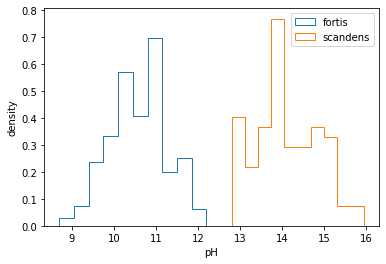

In [30]:
fig,ax = plt.subplots()
ax.hist(finches75[finches75.species=='fortis'].beaklength,density = True,histtype='step',label='fortis');
ax.hist(finches75[finches75.species=='scandens'].beaklength,density = True,histtype='step',label='scandens');
ax.set_ylabel('density')
ax.set_xlabel('pH')
ax.legend()

Convert to one-hot for regression model

In [50]:
its_a_fortis = np.array(finches75.species == 'fortis')
its_a_scandens = np.array(finches75.species=='scandens')
X75 = np.vstack([its_a_fortis,its_a_scandens]).T
X75 = X75.astype(int)

Also get y

In [51]:
y75 = finches75.beaklength

Now instantiate a fitting object

In [52]:
LinearModel = lm.LinearRegression(fit_intercept=False) # Why false-->discuss

Then use it to fit the model

In [53]:
LinearModel.fit(X75,y75)

LinearRegression(fit_intercept=False)

And look at the results!

In [54]:
LinearModel.coef_

array([10.56518987, 14.12091954])

Another example-->
We can answer the age old question of Which is better, red wine or white wine (in portugal, anyway)?

In [55]:
LinearModel = lm.LinearRegression(fit_intercept=False)
LinearModel.fit(X75,y75)
LinearModel.coef_

array([10.56518987, 14.12091954])

Could include some prediction here?

In [65]:
prediction75 = LinearModel.predict(X75)
# Would have been better if we held out some data...but maybe more than is needed for this example.

In [66]:
print(prediction75[0])
print(prediction75[-1])

10.56518987341772
14.120919540229886


Plot residuals

(array([ 2.,  1.,  9.,  8., 16., 22., 29., 26., 44., 48., 30., 45., 33.,
        26., 17., 23., 13.,  5.,  5.,  1.]),
 array([-1.86518987, -1.68097636, -1.49676284, -1.31254932, -1.12833581,
        -0.94412229, -0.75990877, -0.57569526, -0.39148174, -0.20726822,
        -0.02305471,  0.16115881,  0.34537233,  0.52958584,  0.71379936,
         0.89801288,  1.08222639,  1.26643991,  1.45065343,  1.63486694,
         1.81908046]),
 <BarContainer object of 20 artists>)

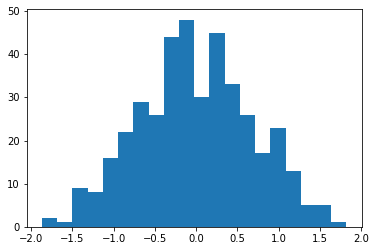

In [69]:
fig,ax = plt.subplots()
ax.hist(y75-prediction75,20)

In [61]:
finches12 = finches[finches.year==2012]
finches12.head()

,band,year,species,beaklength,beakdepth
403,19022,2012,fortis,10.0,8.5
404,19028,2012,fortis,12.5,8.9
405,19032,2012,fortis,9.3,7.5
406,19041,2012,fortis,10.3,9.6
407,19044,2012,fortis,11.0,9.2


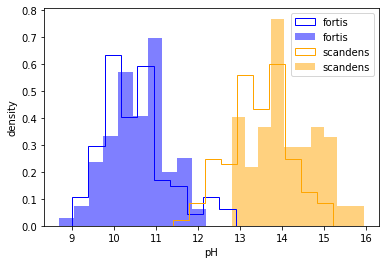

In [48]:
fig,ax = plt.subplots()
ax.hist(finches12[finches12.species=='fortis'].beaklength,density = True,histtype='step',label='fortis',color = 'blue');
ax.hist(finches75[finches75.species=='fortis'].beaklength,density = True,histtype='bar',alpha = .5,label='fortis',color = 'blue');

ax.hist(finches12[finches12.species=='scandens'].beaklength,density = True,histtype='step',label='scandens',color = 'orange');
ax.hist(finches75[finches75.species=='scandens'].beaklength,density = True,histtype='bar',alpha = .5,label='scandens',color = 'orange');

ax.set_ylabel('density')
ax.set_xlabel('pH')
ax.legend()

In [72]:
its_a_fortis = np.array(finches12.species == 'fortis')
its_a_scandens = np.array(finches12.species=='scandens')
X12 = np.vstack([its_a_fortis,its_a_scandens]).T
X12 = X12.astype(int)
y12 = finches12.beaklength

(array([ 1.,  1.,  3.,  7.,  8., 13., 28., 27., 37., 28., 36., 17., 15.,
         8.,  5.,  5.,  1.,  3.,  2.,  3.]),
 array([-2.72091954, -2.46813306, -2.21534657, -1.96256009, -1.70977361,
        -1.45698712, -1.20420064, -0.95141416, -0.69862767, -0.44584119,
        -0.19305471,  0.05973178,  0.31251826,  0.56530474,  0.81809123,
         1.07087771,  1.32366419,  1.57645068,  1.82923716,  2.08202364,
         2.33481013]),
 <BarContainer object of 20 artists>)

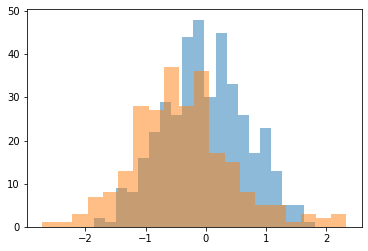

In [75]:
prediction12 = LinearModel.predict(X12)
fig,ax = plt.subplots()
ax.hist(y75-prediction75,20,alpha = .5)
ax.hist(y12-prediction12,20,alpha = .5)